In [1]:
# Standard API
import os
import torch
import pandas as pd
from d2l import torch as d2l
import matplotlib.pyplot as plt

# User defined API (Copyright @NTU,sg)
from ReadingRawGnssDataset import readingRawGnssDataset
from DataLoader_MultipleFile_Random_NoTime import GnssMultipleDataFileLoader
from DataLoader_SingleFile_NoTime import GNSSSingleDataFileLoader

# FCNN-LSTM
from Fcnn_Lstm_parallel import Fcnn_LSTM_encoder
from Fcnn_Lstm_parallel import Fcnn_Lstm
from train_FcnnLstm_parallel import train_fcnn_lstm
from Evaluate_FcnnLstm_parallel import evaluate_fcnnLstm

# Set the global data type
torch.set_default_tensor_type(torch.DoubleTensor)

# Reading Training Dataset

In [2]:
# %% *********************************** Parameter Settings ***********************************
# A minibatch is organized in a tensor with size [batch_size * PRN_size * Input_size]
# input_size = 39
input_size = 55 
PRN_size = 32
res_size = 1
label_size = 3

# %% *********************************** Reading training data in multiple data files ***********************************
training_data_dir = "../data/Dynamic/Data4QE/RouteUS/Training/"
# Get all files in the current directory
training_data_files = os.listdir(training_data_dir)
Xfeatures_list = []
Reslabels_list = []
ylabels_list = []
for data_file in training_data_files:
    # If the object is not a directory, we will open and read it
    data_file_path = training_data_dir+'/'+data_file
    if not os.path.isdir(data_file_path):
        # Read one data file
        data = pd.read_csv(data_file_path)
        inputs, outputs = torch.tensor(data.iloc[:, 0:input_size].values), torch.tensor(data.iloc[:, 14:input_size].values)
        # features, pseudorange residuals, labels
        Xfeatures, Reslabels, ylabels = readingRawGnssDataset(inputs, outputs, input_size, res_size, label_size,
                                                              PRN_size)  # a list of tensors
        # Lists of input data files
        Xfeatures_list.append(Xfeatures)
        Reslabels_list.append(Reslabels)
        ylabels_list.append(ylabels)

# Model Initialization

In [3]:
# %%  *********************************** FCNN-LSTM ***********************************
# Size of input features 
# Elevation (sinE, cosE), Azimuth(sinA, cosA), C/N0, Pseudorange residuals, RSS
# where Pseudorange residual = Corrected pseudorange - geometry range from WLS estimation to satellite - WLS estimation of user clock bias

input_size_debiasing = 7 # Elevation and azimuth are both 2-D features

# Number of hidden neurons of FCNN (MLP)
num_hiddens_debiasing_fcnn = 64

# Number of hidden neurons of LSTM
num_hiddens_debiasing_lstm = 360

# Dropout probability
dropout = 0
encoder = Fcnn_LSTM_encoder(input_size_debiasing, num_hiddens_debiasing_fcnn, 
                                num_hiddens_debiasing_lstm, dropout=0)
net = Fcnn_Lstm(encoder)

# Training Process

Training time per batch:  0.02018538788954417


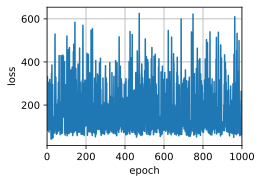

In [8]:
"""Training"""
# # batch size in rural areas
# batch_size = 256 

# batch size in urban areas
batch_size = 32

# Define data iterator
data_iter = GnssMultipleDataFileLoader(Xfeatures_list, Reslabels_list, batch_size)

num_epochs, num_iterations, lr = 1000, 1, 0.000001  # lr is learning rate

checkpoint = torch.load('FcnnLstm_RouteU_4000.tar')
net.load_state_dict(checkpoint['model_state_dict'])

optimizer = train_fcnn_lstm(net, data_iter, lr, num_epochs, num_iterations, d2l.try_gpu())

torch.save({
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'FcnnLstm_RouteU_5000.tar')

# Save the model

In [5]:
# torch.save({
#             'model_state_dict': net.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             }, 'FcnnLstm_RouteR_1100.tar')

# Evaluation

Inference time per sample:  0.008519953415717608


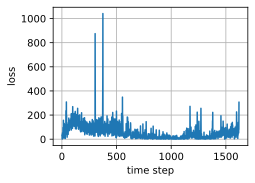

In [3]:
# A minibatch is organized in a tensor with size [batch_size * PRN_size * Input_size]
# For rural areas
input_size = 39
# For urban areas
# input_size = 55
PRN_size = 32
res_size = 1
label_size = 3

# A minibatch is organized in a tensor with size [batch_size * MovingWindowSize * PRN_size * Input_size]
batch_size_eval = 1

# %% *********************************** Reading testing data  ***********************************
data_file_eval = "../data/Dynamic/Data4QE/RouteR/Testing/SvPVT3D_Error_label_dynamic_2020-05-14-US-MTV-1.csv"
data_eval = pd.read_csv(data_file_eval)

inputs_eval, outputs_eval = torch.tensor(data_eval.iloc[:, 0:input_size].values), torch.tensor(data_eval.iloc[:, 14:input_size].values)

# features, pseudorange residuals, labels
x_features_eval, res_labels_eval, y_labels_eval = readingRawGnssDataset(inputs_eval, outputs_eval, input_size, res_size,
                                                                        label_size, PRN_size)  # a list of tensors
plt.figure()
plt.plot(torch.stack([sum(y[y[:,0]!=0, 0])/sum(y[:,0]!=0) for y in y_labels_eval]),
         torch.stack([sum(y[y[:,0]!=0, 1])/sum(y[:,0]!=0) for y in y_labels_eval]), 'v')         
plt.show()

# Define the data iterator for evaluation
data_iter_eval = GNSSSingleDataFileLoader(x_features_eval, res_labels_eval, batch_size_eval)

# %%  *********************************** FCNN-LSTM ***********************************
# Size of input features of Encoder's MLP
# CN0, sinE, cosE, sinA, cosA, PrmResi, RSS
input_size_debiasing = 7 

# Number of hidden neurons of FCNN (MLP)
num_hiddens_debiasing_fcnn = 64

# Number of hidden neurons of LSTM
num_hiddens_debiasing_lstm = 360

encoder = Fcnn_LSTM_encoder(input_size_debiasing, num_hiddens_debiasing_fcnn, 
                                num_hiddens_debiasing_lstm, dropout=0)
model_eval = Fcnn_Lstm(encoder)

# The number of trainable parameters
pytorch_total_params = sum(p.numel() for p in model_eval.parameters() if p.requires_grad)
print(pytorch_total_params)

# Load the trained GnssNet.tar
checkpoint = torch.load('FcnnLstm_RouteR_1300.tar')
model_eval.load_state_dict(checkpoint['model_state_dict'])

# Evaluation
model_eval.eval()
prm_bias = evaluate_fcnnLstm(model_eval, data_iter_eval, batch_size_eval, d2l.try_gpu())

# Write debiased results to a .csv file
prm_bias_np = prm_bias.cpu().detach().numpy()
prm_bias_np_df = pd.DataFrame(prm_bias_np)
prm_bias_np_df.to_csv('PrM_Bias_2020-05-14-US-MTV-1_FcnnLstm.csv',header=False)